In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
import numpy as np
import cv2
import glob
import pandas as pd
import time
import pickle
from skimage.feature import hog
% matplotlib inline

In [2]:
hog_c = pickle.load(open("Hog_classifier/hog-classifier_YCrCb116_shuffle_fulldata.pkl","rb"))   #_YCrCb

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
   
    
def find_cars(img, ystart, ystop,scale, params):
    
    cspace = params['color_space']
    orient = params['orient']
    pix_per_cell = params['pix_per_cell']
    cell_per_block = params['cell_per_block']
    hog_channel = params['hog_channel']
    hog_feat = params['hog_feat']
    X_scaler = params["scaler"]
    svc = params["svc"]
    
    boxes = []
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
            if cspace == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #- cell_per_block +1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #- cell_per_block +1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1 #- cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range( nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            hog_features = np.reshape(hog_features, (1,-1))
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return  boxes #draw_img,

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,60,255), 4)
    # Return the image
    return img

def draw_boxes(img, bboxes, color=(0, 55, 255), thick=4):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Single Image Test

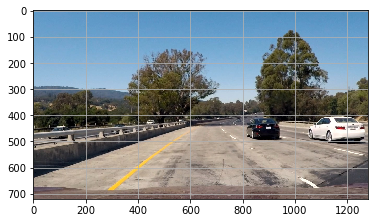

In [4]:
test_img = mpimg.imread('./test_images/test1.jpg')
#test_img1 = cv2.imread("./test_images/test1.jpg")
#test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)

plt.imshow(test_img)
plt.grid(True)

In [96]:
def multi_scale (test_img, hog_c):
    
    bboxes = []
    ystart = 395
    ystop = 440
    scale = 2#1.5
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 400
    ystop = 460
    scale = 2
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 400
    ystop = 500
    scale = 2 #1.5
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 390
    ystop = 470
    scale = 2
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 391
    ystop = 490
    scale = 1.5
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 383
    ystop = 520
    scale = 2
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes) 
    ystart = 375
    ystop = 550
    scale = 2
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 366
    ystop = 580
    scale = 2
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 358
    ystop = 610
    scale = 2
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 350
    ystop = 640
    scale = 2.5
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 400
    ystop = 520
    scale = 2.5
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    ystart = 400
    ystop = 500
    scale = 1.5
    boxes = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes)
    return bboxes

In [ ]:
bboxes

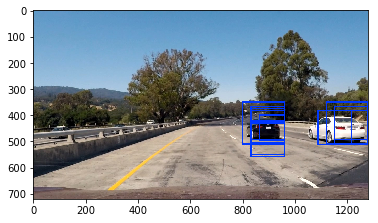

In [122]:
bboxes = multi_scale(test_img1, hog_c)
test = draw_boxes(test_img, bboxes)
plt.imshow(test)

In [ ]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
heat_img = add_heat(heat, bboxes)
plt.imshow(heat_img, cmap= "hot")

In [ ]:
threshold_img = apply_threshold(heat_img, 2)
plt.imshow(threshold_img, cmap = "hot")

In [ ]:
labels = label(threshold_img)
plt.imshow(labels[0], cmap = "gray")

In [ ]:
final = draw_labeled_bboxes(np.copy(test_img), labels)
plt.imshow(final)

Window Multi Scale:

Versuchsbeschreibung:
Angefangen mit dem kleinsten Scale (400-460) max wäre(350-640)
- 6 Schritte Insgesamt
- anhand der Daten zwischenschritte Berechnet von 400 nach 350 in 6 schritten
- und von 460 hoch nach 640 in 6 schritten. 
- scale von 1-3 jeweils für 6 schritte angepasst

##  Testing on all test images

In [98]:
test_images =glob.glob("test_images/test*.jpg")
print(test_images)

['test_images/test5.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test1.jpg', 'test_images/test6.jpg', 'test_images/test4.jpg']


In [120]:
test_list = []
heat_list = []
labels_list = []
final_list = []
for i in test_images:
    img = mpimg.imread(i)
    bboxes = multi_scale(img, hog_c)
    test = draw_boxes(img,bboxes)
    test_list.append(test)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_img = add_heat(heat, bboxes)
    heat_list.append(heat_img)
    if len(bboxes) ==1:
        threshold_img = apply_threshold(heat_img, 0)
    else:
        threshold_img = apply_threshold(heat_img, 1)
    labels = label(threshold_img)
    labels_list.append(labels)
    final = draw_labeled_bboxes(np.copy(img), labels)
    final_list.append(final)
    

In [ ]:
plt.close()

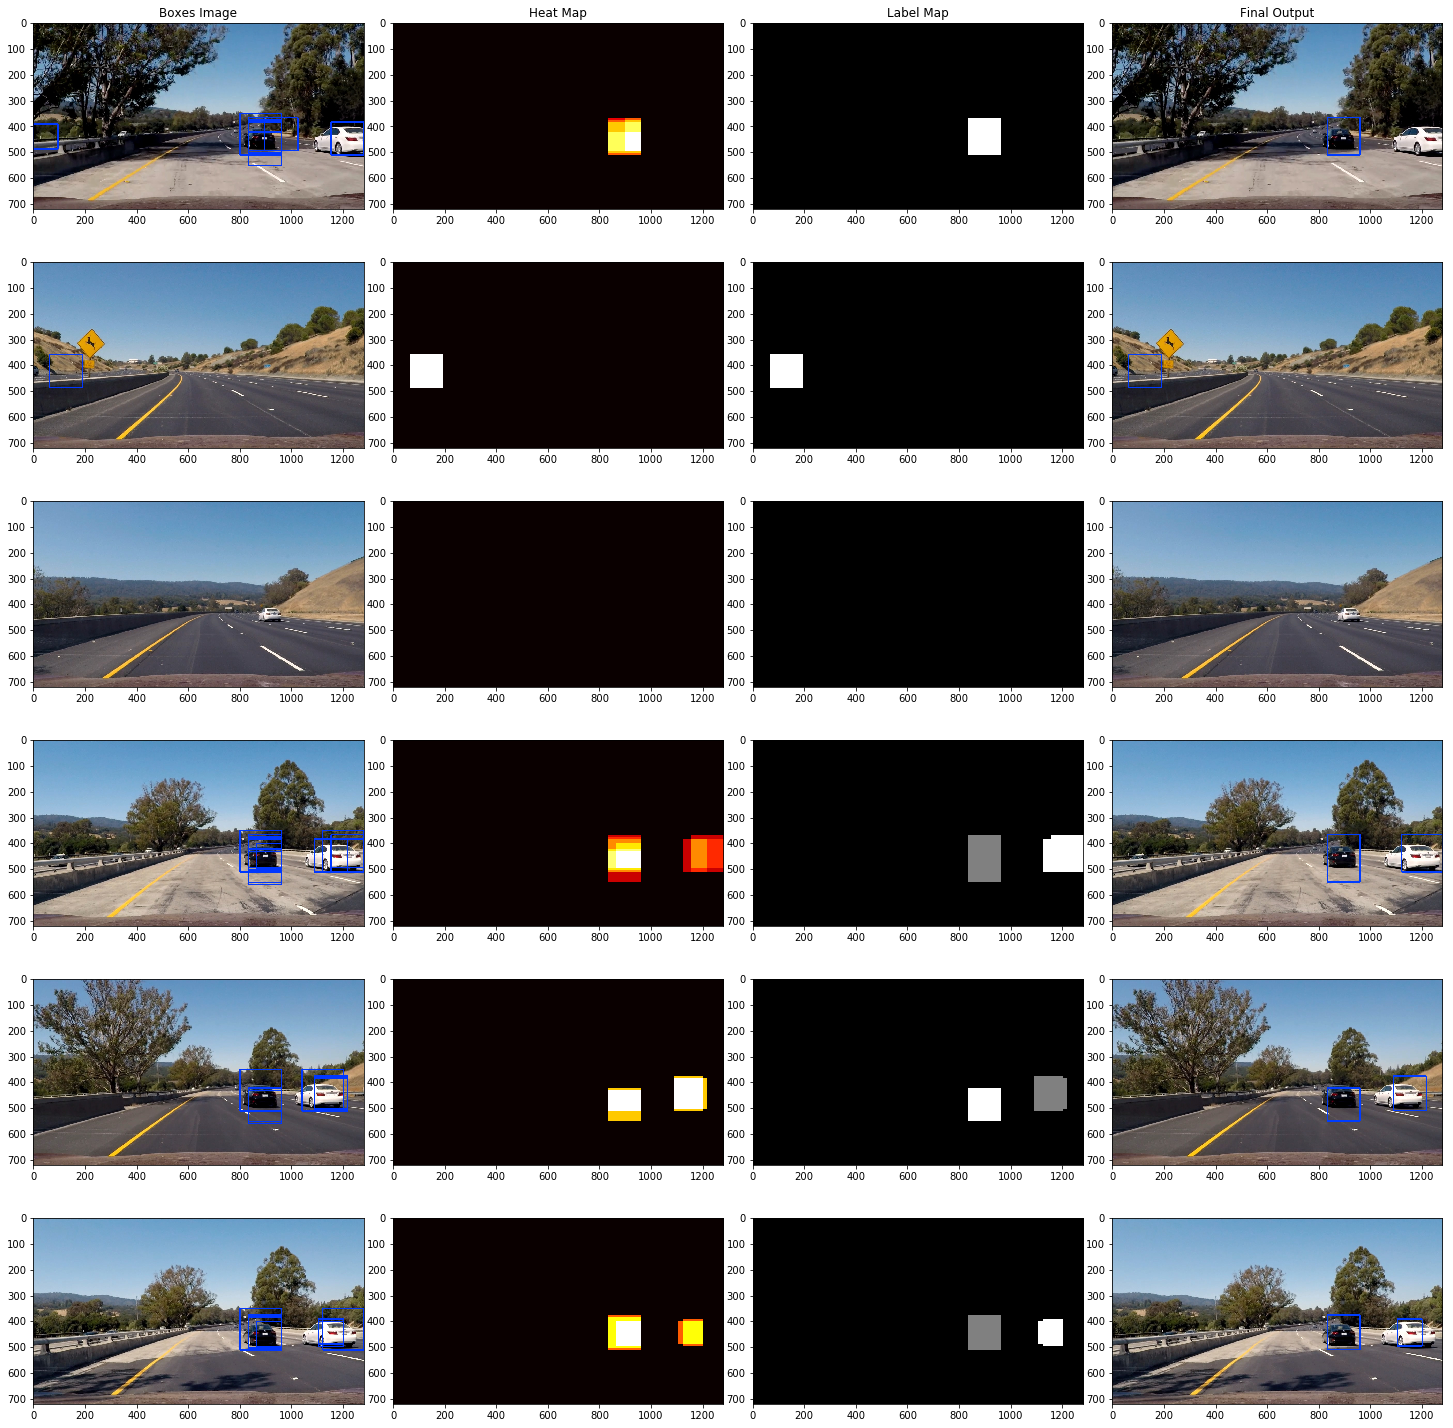

In [121]:
fig, ((a1,a2,a3,a4),(a5,a6,a7,a8),
      (a9,a10,a11,a12),(a13,a14,a15,a16),
      (a17,a18,a19,a20),(a21,a22,a23,a24)) = plt.subplots(6,4, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
#ax = axis.ravel()

a1.set_title("Boxes Image")
a1.imshow(test_list[0])
a5.imshow(test_list[1])
a9.imshow(test_list[2])
a13.imshow(test_list[3])
a17.imshow(test_list[4])
a21.imshow(test_list[5])

a2.set_title("Heat Map")
a2.imshow(heat_list[0],cmap ="hot")
a6.imshow(heat_list[1],cmap ="hot")
a10.imshow(heat_list[2],cmap ="hot")
a14.imshow(heat_list[3],cmap ="hot")
a18.imshow(heat_list[4],cmap ="hot")
a22.imshow(heat_list[5],cmap ="hot")

a3.set_title("Label Map")
a3.imshow(labels_list[0][0],cmap ="gray")
a7.imshow(labels_list[1][0],cmap ="gray")
a11.imshow(labels_list[2][0],cmap ="gray")
a15.imshow(labels_list[3][0],cmap ="gray")
a19.imshow(labels_list[4][0],cmap ="gray")
a23.imshow(labels_list[5][0],cmap ="gray")

a4.set_title("Final Output")
a4.imshow(final_list[0])
a8.imshow(final_list[1])
a12.imshow(final_list[2])
a16.imshow(final_list[3])
a20.imshow(final_list[4])
a24.imshow(final_list[5])
plt.tight_layout(pad=0.2, w_pad=0.25, h_pad=1.0)

In [115]:
class Bboxes_Detection():
    def __init__(self):
        # history of bboxes in previous frames
        self.prev_bboxes = [] 
        
    def add_bboxes(self, bboxes):
        self.prev_bboxes.append(bboxes)
        if len(self.prev_bboxes) > 13:
            # throw out oldest rectangle set(s)
            self.prev_bboxes = self.prev_bboxes[len(self.prev_bboxes)-13:]
        # 10-11 war ok
    def clear(self):
        self.prev_bboxes = []

In [117]:
from scipy.ndimage.measurements import label

detection = Bboxes_Detection()

def detect_veh(img):
    bboxes = multi_scale(img, hog_c)
    if len(bboxes)>0:
        detection.add_bboxes(bboxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    if len(detection.prev_bboxes) > 0:
        for boxes in detection.prev_bboxes:
            heat_img = add_heat(heat, boxes)
        threshold_img = apply_threshold(heat_img, 4+len(detection.prev_bboxes)//2)

        labels = label(threshold_img)
        final = draw_labeled_bboxes(np.copy(img), labels)
    else:
        final = img
    return final

In [118]:
detection.clear()

In [31]:
from moviepy.editor import VideoFileClip
from moviepy.editor import *
from IPython.display import HTML

In [71]:
test_out_file = 'mix.mp4'
clip_test = VideoFileClip('test_video.mp4')
#clip.write_videofile('myvid.webm', codec='libvpx')
clip_test_out = clip_test.fl_image(detect_veh)
%time clip_test_out.write_videofile(test_out_file, audio=False)
detection.clear()

[MoviePy] >>>> Building video mix.mp4
[MoviePy] Writing video mix.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: mix.mp4 

CPU times: user 1min 3s, sys: 3.44 s, total: 1min 7s
Wall time: 18 s


In [119]:
project_out_file = 'final_full.mp4'
clip_test = VideoFileClip('project_video.mp4')#.subclip(1,20)
#clip.write_videofile('myvid.webm', codec='libvpx')
clip_test_out = clip_test.fl_image(detect_veh)
%time clip_test_out.write_videofile(project_out_file, audio=False)

detection.clear()

[MoviePy] >>>> Building video final_full.mp4
[MoviePy] Writing video final_full.mp4


100%|█████████▉| 1260/1261 [08:47<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_full.mp4 

CPU times: user 31min 20s, sys: 1min 41s, total: 33min 1s
Wall time: 8min 48s


- todo: -neue windows testen
- x scalierung anpassen das linke fahrbahn nicht berechnet wird

        

## My Windows

different windows // regions of interest and scales


In [ ]:
#funktioniert "gut"
# Min scale
    bboxes = []
    ystart = 395
    ystop = 440
    scale = 1.5
    boxes0 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes0)
    ystart = 400
    ystop = 460
    scale = 2
    boxes1 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes1)
    ystart = 400
    ystop = 500
    scale = 1.5
    boxes01 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes01)
    ystart = 390
    ystop = 470
    scale = 2
    boxes11 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes11)
    ystart = 391
    ystop = 490
    scale = 1.5
    boxes2 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes2)
    #  1. middle scale
    ystart = 383
    ystop = 520
    scale = 2
    boxes3 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes3)
    #  2. middle scale
    ystart = 375
    ystop = 550
    scale = 2
    boxes4 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes4)
    #print(boxes4)
    # 3. middle scale
    ystart = 366
    ystop = 580
    scale = 2.3
    boxes5 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes5)
    #print(boxes5)
    # Max scale
    ystart = 358
    ystop = 610
    scale = 2.5
    boxes6 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes6)
    #print(boxes6)
    ystart = 350
    ystop = 640
    scale = 2.8
    boxes7 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes7)
  

In [ ]:
#arbeitet mit zwei false positive! 
bboxes = []
    ystart = 395
    ystop = 440
    scale = 2#1.5
    boxes0 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes0)
    ystart = 400
    ystop = 460
    scale = 2
    boxes1 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes1)
    ystart = 400
    ystop = 500
    scale = 2 #1.5
    boxes01 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes01)
    ystart = 390
    ystop = 470
    scale = 2
    boxes11 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes11)
    ystart = 391
    ystop = 490
    scale = 1.5
    boxes2 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes2)
    #  1. middle scale
    ystart = 383
    ystop = 520
    scale = 2
    boxes3 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes3)
    #  2. middle scale
    ystart = 375
    ystop = 550
    scale = 2
    boxes4 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes4)
    #print(boxes4)
    # 3. middle scale
    ystart = 366
    ystop = 580
    scale = 2
    boxes5 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes5)
    #print(boxes5)
    # Max scale
    ystart = 358
    ystop = 610
    scale = 2
    boxes6 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes6)
    #print(boxes6)
    ystart = 350
    ystop = 640
    scale = 2.5
    boxes7 = find_cars(test_img,ystart,ystop,scale, hog_c)
    bboxes.extend(boxes7)
  